In [ ]:
import os
import logging

logging.basicConfig(level=logging.ERROR)

import pandas as pd
from tqdm import tqdm

from src.util import seed_everything, update_avg
from src.config import SEED, INTERIM_DATA_DIR, OPENAI_API_KEY
from src.metrics import calculate_all
from src.data.dataset import create_loaders
from src.models.openai_model import FewShotModel

In [2]:
if not INTERIM_DATA_DIR.exists():
    os.chdir("..")

In [3]:
seed_everything(SEED)

In [4]:
BATCH_SIZE = 32
NUM_BATCHES = 6

In [5]:
train_loader, val_loader, test_loader = create_loaders(
    pd.read_csv(INTERIM_DATA_DIR / "swapped.csv"), batch_size=BATCH_SIZE
)

In [9]:
df = pd.read_csv(INTERIM_DATA_DIR / "swapped.csv")

In [10]:
NUM_TRAIN_SAMPLES = 10

In [13]:
least_toxic = df.nsmallest(NUM_TRAIN_SAMPLES, "trn_tox")
least_toxic.head()

,reference,translation,similarity,lenght_diff,ref_tox,trn_tox
291782,Just what sort of severance package is managem...,and what parting gift am I prepared to offer? ...,0.610122,0.180233,0.993660,0.000033
317462,Just what sort of severance package is managem...,and what parting gift am I prepared to offer? ...,0.610122,0.184971,0.992652,0.000033
489393,"son of a bitch, I used to go from place to pla...","' ""I went from place to place telling friends ...",0.605479,0.243902,0.998660,0.000033
358271,"and the best part is, even though it wasn't al...","And the best thing is, even if they weren't wa...",0.617393,0.390244,0.993636,0.000033
398469,Why every idiot writer and director in Hollywo...,I don't know why he doesn't want one director ...,0.780358,0.108333,0.999624,0.000034


In [14]:
train_samples = (list(least_toxic.reference), list(least_toxic.translation))

In [15]:
model = FewShotModel(OPENAI_API_KEY, *train_samples)

In [16]:
all_predictions = []
all_sources = []
avg_non_tox = 0
avg_bert = 0
avg_bleu = 0
for i, batch in (pbar := tqdm(enumerate(test_loader), total=NUM_BATCHES)):
    inputs, target = batch
    all_sources.extend(inputs)
    test_pred = model.predict(inputs)
    all_predictions.extend(test_pred)
    non_tox, bert, bleu = calculate_all(
        inputs, test_pred[:BATCH_SIZE], target, BATCH_SIZE
    )
    avg_non_tox = update_avg(avg_non_tox, non_tox, i)
    avg_bert = update_avg(avg_bert, bert, i)
    avg_bleu = update_avg(avg_bleu, bleu, i)
    pbar.set_description(f"{avg_non_tox=:.3f} {avg_bert=:.3f} {avg_bleu=:.3f}")
    if i + 1 >= NUM_BATCHES:
        break

  0%|          | 0/6 [00:00<?, ?it/s]Some weights of the model checkpoint at SkolkovoInstitute/roberta_toxicity_classifier_v1 were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
avg_non_tox=0.625 avg_bert=0.532 avg_bleu=0.148:  83%|████████▎ | 5/6 [01:51<00:22, 22.25s/it]


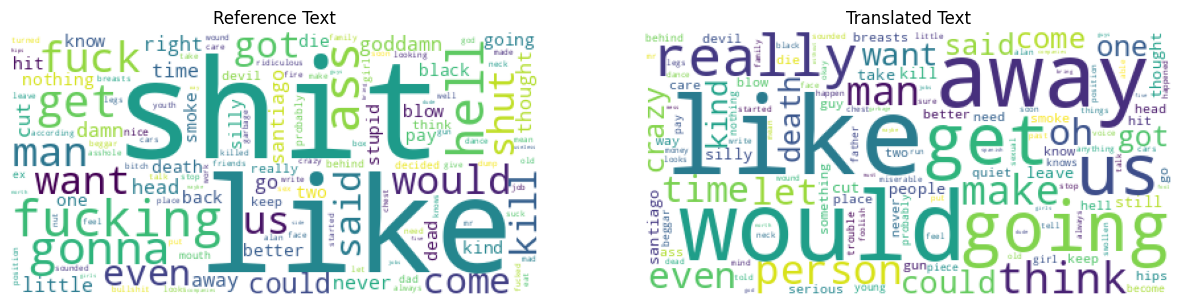

In [19]:
import matplotlib.pyplot as plt
from src.visualization.make_wordcloud import make_wordcloud

_, axes = plt.subplots(1, 2, figsize=(15, 10))

axes[0].imshow(make_wordcloud(pd.Series(all_sources)))
axes[0].axis("off")
axes[0].set_title("Reference Text")

axes[1].imshow(make_wordcloud(pd.Series(all_predictions)))
axes[1].axis("off")
axes[1].set_title("Translated Text")
plt.show()